<a href="https://colab.research.google.com/github/vojtechremis/RADcv/blob/main/01RAD_Homework5_Remis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Name: Vojtěch Remiš

### Individual Student Work — HW

1. Data Exploration and Preprocessing
   - Load the `mpg` dataset; keep relevant variables.
   - For this HW, use `weight` as the response variable (explicit change).
   - Convert `origin` to a categorical variable with three levels (USA, Europe, Japan).
   - Plot relationships between `weight` and each predictor, including grouped plots by `origin`.

2. Initial Model Fitting
   - Fit OLS: `weight ~ horsepower + displacement + acceleration + C(origin)`.
   - Interpret coefficients and p-values in context (units, direction, practical magnitude).

3. Overall F-test vs Individual t-tests
   - Report the global F-test and compare with individual t-tests.
   - Compare $R^2$ with adjusted $R^2$ and explain the difference.

4. Investigate Correlation
   - Identify the two most correlated predictors; remove one and refit.
   - Compare the lighter model to the full model (adjusted $R^2$, F).
   - At fixed values of common predictors (3 settings), vary the removed predictor randomly and compare prediction intervals across models.

5. Categorical Interactions
   - Fit a model with interactions: e.g., `weight ~ displacement * C(origin)` or `horsepower * C(origin)`.
   - Interpret interaction terms and discuss how `origin` moderates effects.

6. Model Selection
   - Perform some kind of stepwise regression.
   - Compare final vs initial models in adjusted $R^2$ and F; discuss trade-offs.

7. Diagnostics
   - Produce residual plots and a Q–Q plot. Comment on normality, homoscedasticity, and any influential points.

*Source: 01RAD_Ex05_python.ipynb*

In [1]:
# Import libraries

# Imports: data handling, modeling, plots, and utilities
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm

# Configure plotting style and reproducibility
sns.set_theme(style="whitegrid", context="notebook")
plt.style.use("ggplot")
pd.set_option("display.float_format", lambda value: f"{value:,.3f}")
RNG = np.random.default_rng(42)
warnings.filterwarnings("ignore", category=FutureWarning, module="statsmodels")

## 1. Data Exploration and Preprocessing
   - Load the `mpg` dataset; keep relevant variables.
   - For this HW, use `weight` as the response variable (explicit change).
   - Convert `origin` to a categorical variable with three levels (USA, Europe, Japan).
   - Plot relationships between `weight` and each predictor, including grouped plots by `origin`.

Dataset shown below: 


,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.000,8,307.000,130.000,3504,12.000,70,usa,chevrolet chevelle malibu
1,15.000,8,350.000,165.000,3693,11.500,70,usa,buick skylark 320
2,18.000,8,318.000,150.000,3436,11.000,70,usa,plymouth satellite
3,16.000,8,304.000,150.000,3433,12.000,70,usa,amc rebel sst
4,17.000,8,302.000,140.000,3449,10.500,70,usa,ford torino



Missing values per column:
mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model_year      0
origin          0
name            0
dtype: int64

Number of rows removed: 6
Unique values in "origin" column: ['usa' 'japan' 'europe']


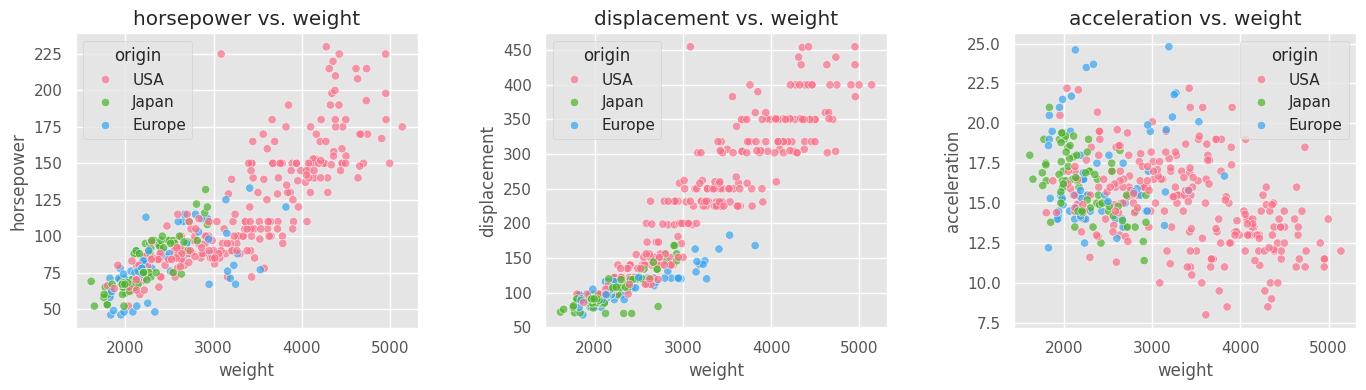

In [2]:
# 1) Load dataset and keep only relevant vars
mpg_df = sns.load_dataset('mpg')
print('Dataset shown below: ')
display(mpg_df.head())

original_df_len = len(mpg_df)

print(
    '\nMissing values per column:\n'
    f'{mpg_df.isna().sum()}'
    )
# Drop rows with missing values
mpg_df.dropna(inplace=True)
print(f'\nNumber of rows removed: {original_df_len - len(mpg_df)}')

predictor_vars = ['horsepower', 'displacement', 'acceleration', 'origin']
response_var = 'weight'
mpg_df.drop(columns=set(mpg_df.columns) - set(predictor_vars + [response_var]), inplace=True)  # Keeping only selected variables

# 2) Convert 'origin' to categorical var with 3 levels (USA, Europe, Japan)
print(f'Unique values in "origin" column: {mpg_df["origin"].unique()}')
origin_categories = {
    'japan': 'Japan',
    'europe': 'Europe',
    'usa': 'USA'
}
mpg_df['origin'] = mpg_df['origin'].map(origin_categories)

# 3) Plot relationships between 'weight' and each predictor, including grouped plots by 'origin'
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, predictor_var in zip(axes, predictor_vars):
    sns.scatterplot(
        data=mpg_df,
        x='weight', y=predictor_var,
        hue='origin', palette='husl', ax=ax, alpha=0.7
    )
    ax.set_title(f'{predictor_var} vs. weight')

axes[0].set_xlabel('weight')

plt.subplots_adjust(wspace=25)
plt.tight_layout()
plt.show()

## 2. Initial Model Fitting
   - Fit OLS: `weight ~ horsepower + displacement + acceleration + C(origin)`.
   - Interpret coefficients and p-values in context (units, direction, practical magnitude).

In [3]:
initial_model = smf.ols('weight ~ horsepower + displacement + acceleration + C(origin)', data=mpg_df).fit()
print('Summary table of initial model:')
display(initial_model.summary2().tables[1])

Summary table of initial model:


,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,-91.803,157.212,-0.584,0.560,-400.903,217.296
C(origin)[T.Japan],-121.748,43.899,-2.773,0.006,-208.060,-35.437
C(origin)[T.USA],-49.879,44.373,-1.124,0.262,-137.122,37.364
horsepower,8.582,0.968,8.867,0.000,6.679,10.485
displacement,5.717,0.357,16.029,0.000,5.016,6.418
acceleration,71.879,6.898,10.421,0.000,58.318,85.440


### Task #2 Conclusion

1. The coefficient for the **Intercept** represents the estimated weight of a car when all predictors are equal to zero (and for the `Europe` region). Such a combination has no logical meaning (`horsepower` = 0, …), and the coefficient is statistically insignificant (p = 0.560).

2. The coefficient for **`C(origin)[T.Japan]`** represents how much the car’s weight changes for cars from **Japan** relative to cars from **Europe** (with all other predictors held constant). The p-value is 0.006, so the decrease of approximately **121.75 units** for Japanese cars compared to European ones is statistically significant.

3. The coefficient for **`C(origin)[T.USA]`** represents, analogously to Japan, how much the car’s weight changes for cars from the **USA** relative to **Europe** (the baseline). In this case, the reduction in weight is statistically insignificant (p = 0.262).

4. The coefficient for **`horsepower`** means that for each one-unit increase in horsepower, the car’s weight increases by approximately **8.58 units** (p ≈ 0 → statistically significant).

5. The coefficient for **`displacement`** means that for each one-unit increase in displacement, the car’s weight increases by approximately **5.72 units** (p ≈ 0 → statistically significant).

6. The coefficient for **`acceleration`** means that for each one-unit increase in acceleration, the car’s weight increases by approximately **71.88 units** (p ≈ 0 → statistically significant).

## 3. Overall F-test vs Individual t-tests
   - Report the global F-test and compare with individual t-tests.
   - Compare $R^2$ with adjusted $R^2$ and explain the difference.

In [4]:
# Overall F-test vs individual t-tests for the initial model
print('Overall F-test:')
print(f'With intercept: R^2 = {initial_model.rsquared:.4f}, \tAdj_R^2 = {initial_model.rsquared_adj:.4f}, \tF = {initial_model.fvalue:.2f}, \tp(F) = {initial_model.f_pvalue:.3g}, \tAIC = {initial_model.aic:.1f}\n\n')

Overall F-test:
With intercept: R^2 = 0.9047, 	Adj_R^2 = 0.9035, 	F = 732.81, 	p(F) = 1.64e-194, 	AIC = 5489.7




### Task #3 Conclusion

#### Global F-test
The global F-test shows that the model as a whole is statistically significant (p ≈ 0). This implies that at least one of the predictors must be statistically significant.

#### Individual t-tests
The predictors `displacement`, `acceleration`, and `horsepower` are statistically significant with strongly positive coefficients. The predictor `C(origin)[T.Japan]` is also statistically significant with a negative coefficient, meaning that cars from Japan are, on average, lighter than cars from Europe. The remaining predictors are statistically insignificant.

#### R² and Adjusted R²
R² shows that the model explains **90.47%** of the variance in `weight`. Adjusted R² shows that the model explains **90.35%** of the variance, which is slightly lower. This may indicate that the model contains an unnecessary predictor; however, the difference is small, so it is unlikely that the model is meaningfully overfitted.

## 4. Investigate Correlation
   - Identify the two most correlated predictors; remove one and refit.
   - Compare the lighter model to the full model (adjusted $R^2$, F).
   - At fixed values of common predictors (3 settings), vary the removed predictor randomly and compare prediction intervals across models.

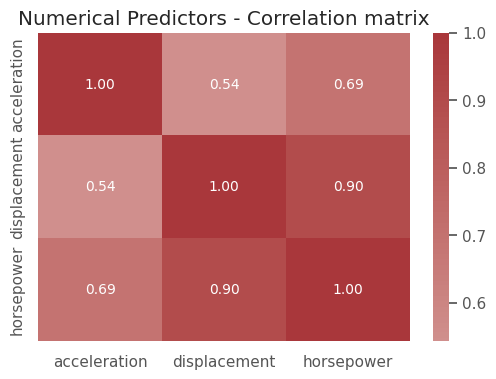

Most correlated pair of features: "('displacement', 'horsepower')"
Dropping "horsepower"

Initial model R^2: 0.9047 	vs. Reduced model R^2: 0.8853
Initial model Adj. R^2: 0.9035 	vs. Reduced model Adj. R^2: 0.8841
Initial model F: 732.8091 	vs. Reduced model F: 746.5988


,quantile_setting,fixed_displacement,fixed_acceleration,fixed_origin,mean_PI_width_full,mean_PI_width_reduced,mean_bias
0,0.250,105.000,13.775,USA,"1,087.134","1,147.961",-489.138
1,0.500,151.000,15.500,USA,"1,078.003","1,141.988",-431.989
2,0.750,275.750,17.025,USA,"1,063.297","1,141.411",-145.686


In [5]:
# 1) Identify the two most correlated predictors
predictor_vars_numeric = list(set(predictor_vars) - {'origin'})
predictors_corr = mpg_df[predictor_vars_numeric].corr().abs()
stacked = predictors_corr.where(~np.eye(len(predictor_vars_numeric), dtype=bool)).stack()
most_corr_pair = stacked.idxmax()

# 2) Show correlation matrix
plt.figure(figsize=(6, 4))
sns.heatmap(predictors_corr, annot=True, cmap='vlag', center=0, fmt='.2f')
plt.title('Numerical Predictors - Correlation matrix')
plt.show()

# 3) Remove one of the most correlated predictors
if 'horsepower' in most_corr_pair:
    dropped_predictor = 'horsepower'
else:
    raise ValueError('Most correlated pair not consistent with one during initial analysis.')

print(
    f'Most correlated pair of features: "{most_corr_pair}"\n'
    f'Dropping "{dropped_predictor}"\n'
)
mpg_df_reduced = mpg_df.drop(columns=[dropped_predictor])

# 4) Refit the model
initial_model_reduced = smf.ols('weight ~ displacement + acceleration + C(origin)', data=mpg_df_reduced).fit()

# 5) Compare the models
print(f'Initial model R^2: {initial_model.rsquared:.4f} \tvs. Reduced model R^2: {initial_model_reduced.rsquared:.4f}')
print(f'Initial model Adj. R^2: {initial_model.rsquared_adj:.4f} \tvs. Reduced model Adj. R^2: {initial_model_reduced.rsquared_adj:.4f}')
print(f'Initial model F: {initial_model.fvalue:.4f} \tvs. Reduced model F: {initial_model_reduced.fvalue:.4f}')

# 6) At fixed common predictors, vary the removed predictor and compare prediction interval widths
min_dropped = mpg_df[dropped_predictor].min()
max_dropped = mpg_df[dropped_predictor].max()

quantiles = [0.25, 0.5, 0.75]
rows = []
predictor_vars_kept_numeric = list(set(predictor_vars_numeric) - {dropped_predictor})

for q in quantiles: # Generate each settig as a quantile value (except origin)
    # Fixed settings for kept predictors
    setting = {v: mpg_df[v].quantile(q) for v in predictor_vars_kept_numeric}
    setting['origin'] = 'USA'

    # Generate values of removed predictor
    n_points = 200
    dropped_values = RNG.uniform(min_dropped, max_dropped, size=n_points)

    # DataFrame for full model
    df_full = pd.DataFrame([{**setting, dropped_predictor: x} for x in dropped_values])

    # Predictions
    pred_full = initial_model.get_prediction(df_full).summary_frame(alpha=0.05)
    pred_reduced = initial_model_reduced.get_prediction(
        df_full.drop(columns=[dropped_predictor])
    ).summary_frame(alpha=0.05)


    # Mean prediction interval widths
    width_full = (pred_full['obs_ci_upper'] - pred_full['obs_ci_lower']).mean()
    width_reduced = (pred_reduced['obs_ci_upper'] - pred_reduced['obs_ci_lower']).mean()

    # Mean bias
    mean_full_pred = pred_full['mean'].mean()
    mean_reduced_pred = pred_reduced['mean'].mean()
    bias = mean_reduced_pred - mean_full_pred

    # Build output row with individual columns for each fixed predictor
    row = {
        'quantile_setting': q,
        'mean_PI_width_full': width_full,
        'mean_PI_width_reduced': width_reduced,
        'mean_bias': bias,
    }

    # Add each predictor to summary table
    for key, val in setting.items():
        row[f"fixed_{key}"] = val

    rows.append(row)

# Final table
pi_compare_df = pd.DataFrame(rows)
display(pi_compare_df[['quantile_setting', 'fixed_displacement', 'fixed_acceleration', 'fixed_origin', 'mean_PI_width_full', 'mean_PI_width_reduced', 'mean_bias']])

### Task #04 Conclusion

1. The two most strongly correlated predictors in the dataset were **horsepower** and **displacement**, so **horsepower** was removed to assess the impact of multicollinearity. After refitting, the reduced model showed a lower adjusted R² (**0.89** vs. **0.90**), indicating a small loss in explanatory power, even though the F-statistic remained comparably high.

2. To evaluate predictive performance, *horsepower* was randomly varied while keeping the remaining predictors fixed at three representative settings. Across all settings, the reduced model consistently produced **wider prediction intervals** and exhibited **systematic negative bias** (–489 to –146), while the full model maintained narrower intervals and more accurate predictions. These results demonstrate that despite the high correlation between horsepower and displacement, removing horsepower leads to a clear degradation in predictive performance, and the **full model is therefore preferable**.

### 5. Categorical Interactions
   - Fit a model with interactions: e.g., `weight ~ displacement * C(origin)` or `horsepower * C(origin)`.
   - Interpret interaction terms and discuss how `origin` moderates effects.

In [6]:
# Model with categorical interactions: weight ~ horsepower * C(origin) + displacement + acceleration
interaction_model = smf.ols('weight ~ horsepower * C(origin) + displacement + acceleration', data=mpg_df).fit()

print('Interaction model summary:')
display(interaction_model.summary2().tables[1])

print(f'Initial model Adj. R^2: {initial_model.rsquared_adj:.4f} \tvs. Interaction model Adj. R^2: {interaction_model.rsquared_adj:.4f}')


Interaction model summary:


,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,-965.450,191.865,-5.032,0.000,"-1,342.688",-588.213
C(origin)[T.Japan],4.728,175.430,0.027,0.979,-340.196,349.652
C(origin)[T.USA],843.942,134.192,6.289,0.000,580.100,"1,107.785"
horsepower,16.599,1.591,10.431,0.000,13.470,19.728
horsepower:C(origin)[T.Japan],-1.364,2.128,-0.641,0.522,-5.548,2.819
horsepower:C(origin)[T.USA],-11.354,1.616,-7.028,0.000,-14.530,-8.177
displacement,6.878,0.354,19.444,0.000,6.182,7.573
acceleration,77.866,6.365,12.233,0.000,65.350,90.382


Initial model Adj. R^2: 0.9035 	vs. Interaction model Adj. R^2: 0.9188


### Task #05 Conclusion – Interaction Model

1. **Interaction terms (`horsepower:C(origin)`) allow the slope of horsepower to vary across regions.**  
   In the initial model, the effect of horsepower on weight was assumed to be identical across Europe, Japan, and the USA.  
   The interaction model relaxes this assumption, which leads to an increase in adjusted R² from **0.9035** to **0.9188**, indicating a better fit and a more realistic representation of regional differences.

2. **The baseline category is `Europe`, so the coefficient for `horsepower` represents the slope for European cars.**  
   The value **16.60** means that for European cars, each additional horsepower is associated with an increase of approximately **16.6 units** in weight.  
   This effect is statistically significant (p ≈ 0).

3. **`horsepower:C(origin)[T.Japan]` measures how much the slope differs for Japanese cars compared to European ones.**  
   The coefficient **–1.36** (p = 0.522) indicates that the slope in Japan is slightly lower, but the difference is not statistically significant.

4. **`horsepower:C(origin)[T.USA]` measures how much the slope differs for U.S. cars compared to European ones.**  
   The coefficient **–11.35** (p ≈ 0) indicates a substantial and statistically significant decrease:  
   - USA slope = 16.60 – 11.35 ≈ **5.25**  
   => Horsepower is a much weaker predictor of weight for U.S. cars.

5. **The main effects `C(origin)[T.Japan]` and `C(origin)[T.USA]` now represent differences in intercepts — that is, baseline weight levels.**  
   - Japan: **4.73**, p = 0.979 => statistically insignificant difference from Europe.  
   - USA: **843.94**, p ≈ 0 => U.S. cars have a statistically significant higher baseline weight level than European ones, even after adjusting for other predictors.

6. **Other continuous predictors (`displacement`, `acceleration`) remain strong and stable contributors to the model.**  
   - Displacement: **6.88** per unit (p ≈ 0).  
   - Acceleration: **77.87** per unit (p ≈ 0).  
   Their effects are consistent with those observed in the initial model.

7. **The intercept is –965.45 and statistically significant (p ≈ 0).**  
   While its direct interpretation is not meaningful (as discussed with initial model), its significance is probably due to the model's more flexible structure under interactions.

8. **Conclusion:**  
   - European and Japanese cars share a similar, strong relationship between horsepower and weight.  
   - U.S. cars exhibit a **much weaker** horsepower–weight relationship.  
   - The initial model (without interactions) could not uncover this pattern, which explains the improvement in adjusted R².

### 6. Model Selection
   - Perform some kind of stepwise regression.
   - Compare final vs initial models in adjusted $R^2$ and F; discuss trade-offs.

In [7]:
# 0) NOTE: Alternatively we may use 'mlxtend.feature_selection' (according to the Ex05 Lecture)

# 1) Prepare terms and fit_model function

# Factor terms to be tested
factor_terms  = ['C(origin)']

# Interaction terms to be tested
interaction_terms = [
    'horsepower:C(origin)',
    'displacement:C(origin)',
    'acceleration:C(origin)'
]

# All terms to be tested
terms = predictor_vars_numeric + factor_terms + interaction_terms


# Fit model function
def fit_model(term_list):
    """
    1. Builds model formula.
    2. Fits a linear model with given terms.
    """
    if not term_list:
        formula = 'weight ~ 1'
    else:
        formula = 'weight ~ ' + ' + '.join(term_list)
    model = smf.ols(formula, data=mpg_df).fit()
    return model, formula


# 2) Stepwise AIC – both directions

current_terms = []   # Start with empty model (no predictors => weight ~ 1 => intercept-only model)
current_model, current_formula = fit_model(current_terms)
current_aic = current_model.aic

improved = True

while improved:
    improved = False
    best_addition = None
    best_removal = None

    # Add predictor (try if improvement)
    for t in terms:
        if t not in current_terms:
            trial_terms = current_terms + [t]
            trial_model, _ = fit_model(trial_terms)
            if trial_model.aic < current_aic - 1e-6:
                best_addition = t
                best_add_model = trial_model
                best_add_aic = trial_model.aic
                improved = True

    # Remove predictor (try if improvement)
    if current_terms:
        for t in current_terms:
            trial_terms = [x for x in current_terms if x != t]
            trial_model, _ = fit_model(trial_terms)
            if trial_model.aic < current_aic - 1e-6:
                best_removal = t
                best_rem_model = trial_model
                best_rem_aic = trial_model.aic
                improved = True

    # No improvement => stop
    if not improved:
        break

    # Prefer the smallest AIC among addition vs removal
    candidates = []

    if best_addition is not None:
        candidates.append(('add', best_add_aic, best_addition, best_add_model))
    if best_removal is not None:
        candidates.append(('remove', best_rem_aic, best_removal, best_rem_model))

    # pick operation with min AIC
    op, new_aic, term, new_model = min(candidates, key=lambda x: x[1]) # AIC is in the second position

    if op == 'add':
        current_terms.append(term)
    elif op == 'remove':
        current_terms.remove(term)

    current_model = new_model
    current_aic = new_aic

# 3) Final results
selected_formula = 'weight ~ ' + ' + '.join(current_terms) if current_terms else 'weight ~ 1'

print('Selected model (both-direction stepwise AIC):')
print(f'\tFormula:      {selected_formula}')
print(f'\tAIC:          {current_model.aic:.2f}')
print(f'\tAdjusted R^2: {current_model.rsquared_adj:.4f}')
print(f'\tF-statistic:  {current_model.fvalue:.2f}, p(F) = {current_model.f_pvalue:.3g}')

print("\nComparison to initial model:")
print(f'\tInitial Adj R^2: {initial_model.rsquared_adj:.4f}')
print(f'\tStepwise Adj R^2: {current_model.rsquared_adj:.4f}')

Selected model (both-direction stepwise AIC):
	Formula:      weight ~ acceleration:C(origin) + displacement:C(origin) + horsepower:C(origin) + C(origin)
	AIC:          5413.32
	Adjusted R^2: 0.9217
	F-statistic:  419.59, p(F) = 6.9e-205

Comparison to initial model:
	Initial Adj R^2: 0.9035
	Stepwise Adj R^2: 0.9217


### Task #06 Conclusion

1. Using bidirectional stepwise selection based on **AIC**, the algorithm evaluated all numerical predictors, the factor `origin`, and interaction terms with region-specific slopes.
2. Starting from an intercept-only model and allowing both additions and removals of predictors, the procedure selected a model containing only `C(origin)` and its three interactions (`horsepower:C(origin)`, `displacement:C(origin)`, `acceleration:C(origin)`), indicating that weight is best explained through region-dependent effects rather than global main effects.
3. The resulting model achieved **AIC = 5413.32** and **Adjusted R² = 0.9217**, outperforming the initial model (**Adjusted R² = 0.9035**) and demonstrating that regional interaction structure leads to a better fit.

### 7. Diagnostics
   - Produce residual plots and a Q–Q plot. Comment on normality, homoscedasticity, and any influential points.

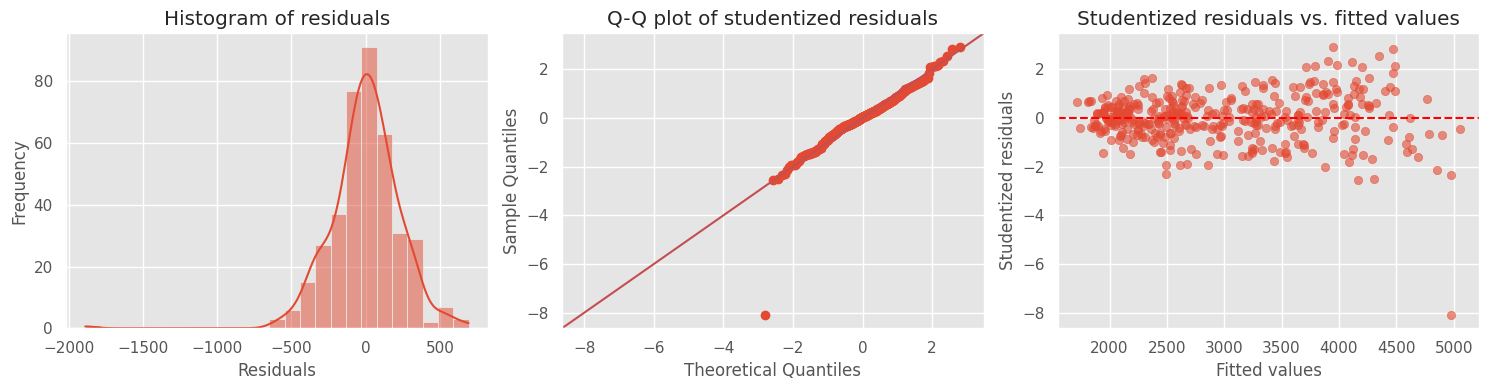

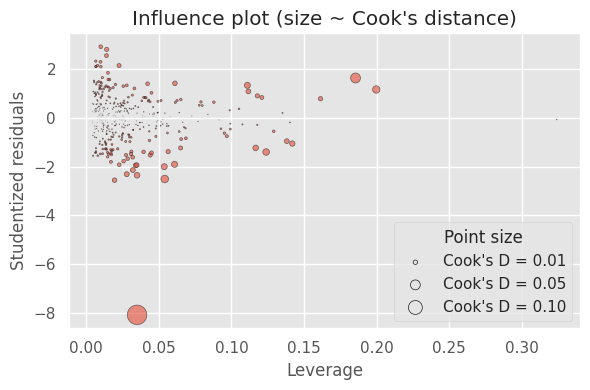

In [8]:
# Diagnostics for the final (stepwise) model
# 1) Extracting the final model components
model_for_diag = current_model

resid = model_for_diag.resid
fitted = model_for_diag.fittedvalues
influence = model_for_diag.get_influence()
studentized = influence.resid_studentized_internal

# 2) Create figure
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 3) Histogram of residuals
sns.histplot(resid, bins=25, kde=True, ax=axes[0])
axes[0].set_title("Histogram of residuals")
axes[0].set_xlabel("Residuals")
axes[0].set_ylabel("Frequency")

# 4) Q-Q plot of studentized residuals
sm.qqplot(studentized, line="45", ax=axes[1])
axes[1].set_title("Q-Q plot of studentized residuals")

# 5) Residuals vs fitted values
axes[2].scatter(fitted, studentized, alpha=0.6)
axes[2].axhline(0, color="red", linestyle="--")
axes[2].set_xlabel("Fitted values")
axes[2].set_ylabel("Studentized residuals")
axes[2].set_title("Studentized residuals vs. fitted values")

plt.subplots_adjust(wspace=0.4)
plt.tight_layout()
plt.show()

# 6) Influence points
influence = model_for_diag.get_influence()
leverage = influence.hat_matrix_diag
cooks = influence.cooks_distance[0]

fig, ax = plt.subplots(figsize=(6, 4))

sc = ax.scatter(
    leverage,
    studentized,
    s=1000 * cooks,
    alpha=0.6,
    edgecolor="k"
)

ax.set_xlabel("Leverage")
ax.set_ylabel("Studentized residuals")
ax.set_title("Influence plot (size ~ Cook's distance)")

for cd in [0.01, 0.05, 0.10]:
    ax.scatter([], [], s=1000 * cd, edgecolor="k", facecolor="none",
               label=f"Cook's D = {cd:.02f}")

ax.legend(title="Point size")
plt.tight_layout()
plt.show()


### Tak #07 Conclusion

**Overall**, the diagnostic plots indicate that the final stepwise model satisfies the key assumptions of linear regression.
1. The `histogram of residuals` is approximately bell-shaped with only mild deviations in the tails (especially at the left tail), suggesting that the normality assumption is reasonably met.
2. The `Q-Q plot` of studentized residuals shows points lying very close to the 45° reference line, with only slight departures at the extremes, which is acceptable for real data.
3. The plot of studentized residuals versus fitted values does not display any systematic structure, trend, or funnel shape, indicating no visible heteroskedasticity or nonlinearity. While a few studentized residuals exceed the +-2 range, this is normal since about 95% of values are expected to lie within this interval under ideal normality.
4. The `influence plot` shows that one observation (bottom left) is by far the most problematic point. It has an unusually large Cook’s distance (will be discoused later in the course), which indicates that it combines both high leverage (i.e., it lies far from the center of the predictor space) and a very large studentized residual (i.e., the model fits this point poorly). Because of this combination, observation (bottom left) has a disproportionately large impact on the fitted regression model.

Note:
$D_i = \frac{\hat{r}_i^2}{m + 1}\left(\frac{h_{ii}}{1 - h_{ii}}\right)$